In [1]:
import rclpy
import cv2
from sensor_msgs.msg import Image, PointCloud2
from matplotlib import pyplot as plt
import pymoveit2 
from rclpy.callback_groups import ReentrantCallbackGroup
from threading import Thread
from pymoveit2 import MoveIt2
%matplotlib widget
rclpy.init()

In [2]:
node = rclpy.create_node("jupyter")
msg = None
depth = None
points = None

def depth_listener_callback(data):
    global depth
    depth = data

def points_listener_callback(data):
    global points
    points = data

def listener_callback(data):
    global msg
    msg = data

subs = [node.create_subscription(
            Image,
            '/realsense/'+n,
            cb,
            10) for (n, cb) in [("image", listener_callback),
                                ("depth_image", depth_listener_callback),
                                ]]

node.create_subscription(
            PointCloud2,
            '/realsense/points',
            points_listener_callback,
            10)

callback_group = ReentrantCallbackGroup()
moveit2 = MoveIt2(node=node, 
                  joint_names=['ur5_shoulder_pan_joint', 'ur5_shoulder_lift_joint',
                               'ur5_elbow_joint','ur5_wrist_1_joint',
                               'ur5_wrist_2_joint','ur5_wrist_3_joint'],
                  base_link_name='ur5_base_link',
                  end_effector_name='gripper',
                  group_name='arm',
                  callback_group=callback_group )

# Spin the node in background thread(s) and wait a bit for initialization
executor = rclpy.executors.MultiThreadedExecutor(2)
executor.add_node(node)
executor_thread = Thread(target=executor.spin, daemon=True, args=())
executor_thread.start() # Using threads, our node will keep spinning while we code 

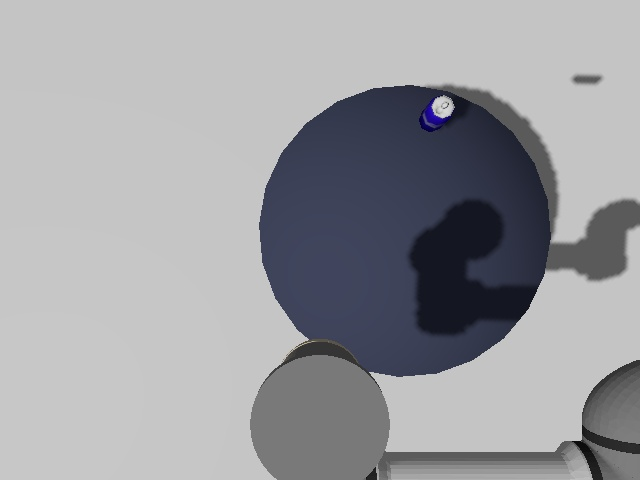

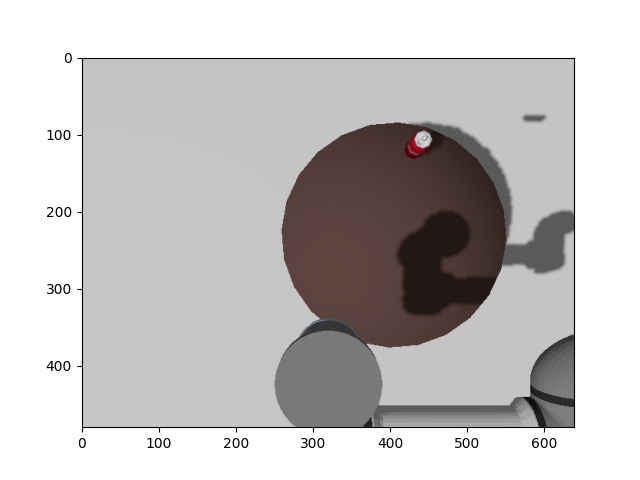

In [3]:
import cv2
import numpy as np
from sensor_msgs.msg import Image

# Assuming msg contains the image data
height = msg.height
width = msg.width
channels = msg.step // width
img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, channels)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


from IPython.display import display, Image as IPImage
from PIL import Image as PILImage
import io

# Convert OpenCV image to PIL image
_, buffer = cv2.imencode('.jpg', img)
io_buf = io.BytesIO(buffer)
pil_image = PILImage.open(io_buf)

# Display the image
display(pil_image)
plt.imshow(img)

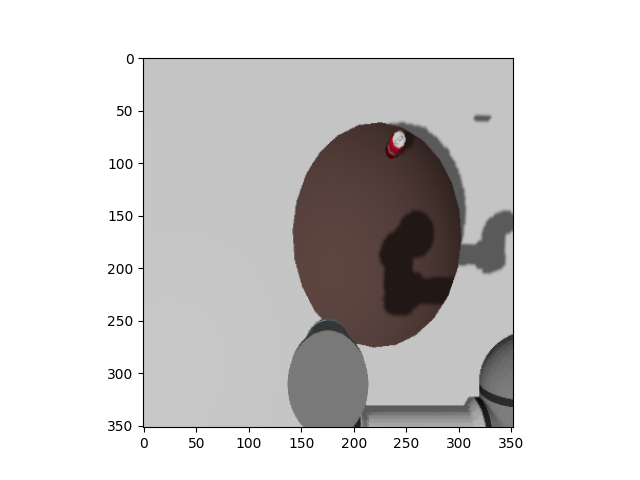

In [4]:
target_size = (352, 352)
original_height = 640
original_width = 480

res_img = cv2.resize(img, (352,352))

# Create the mapping from resized image to original image
mapping = np.zeros((target_size[1], target_size[0], 2), dtype=int)

for i in range(target_size[1]):
    for j in range(target_size[0]):
        original_i = int(i * original_height / target_size[1])
        original_j = int(j * original_width / target_size[0])
        mapping[i, j] = [original_i, original_j]

plt.imshow(res_img)
plt.show()

/workspace/myenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


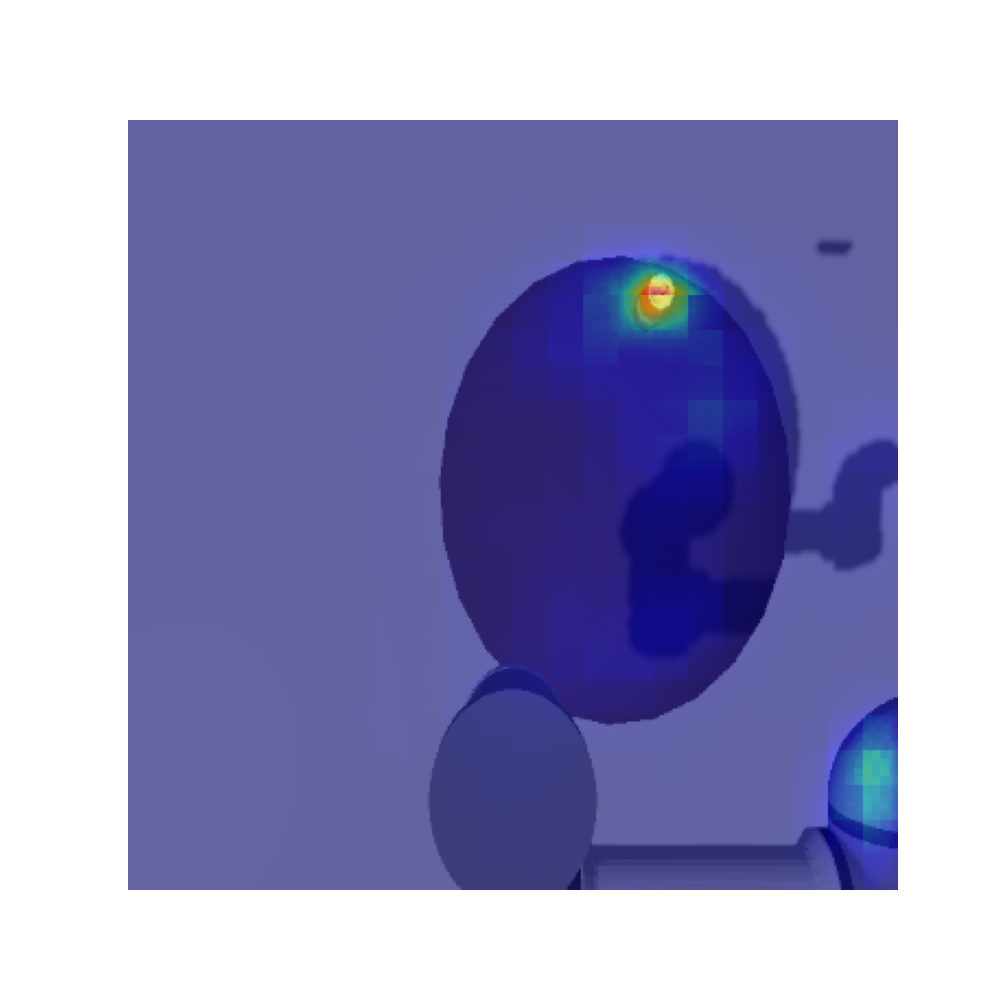

In [5]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

inputs = processor(text="a can of soda", images=res_img, return_tensors="pt")

outputs = model(**inputs)
mask = outputs.logits.sigmoid().detach().cpu().numpy()[0,:,:]

#depth_image = np.frombuffer(depth.data, dtype=np.float32).reshape(msg.height, msg.width)


plt.figure(figsize=(10, 10))
plt.imshow(res_img)
plt.imshow(mask, alpha=0.5, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.axis("off")
plt.show()

In [14]:
upscaled_mask = np.zeros(img.shape)
for i in range(0, res_img.shape[0]):
    for j in range(0, res_img.shape[1]):
        orig_i, orig_j = mapping[i,j]
        upscaled_mask[orig_i-1, orig_j-1] = res_img[i,j]

IndexError: index 480 is out of bounds for axis 0 with size 480

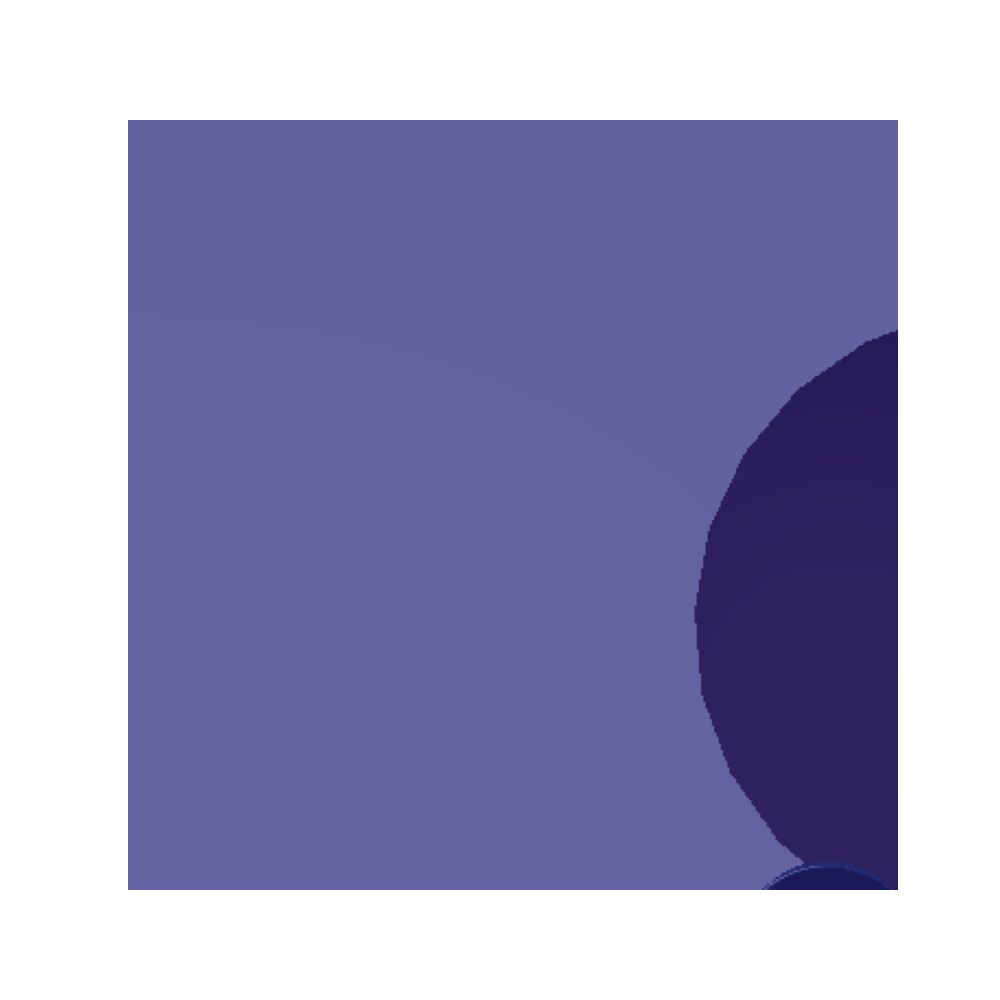

In [7]:

filtered_mask = mask.copy()
filtered_mask[mask < 0.5] =0

plt.figure(figsize=(10, 10))
plt.imshow(img[:352,:352])
plt.imshow(filtered_mask, alpha=0.5, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.axis("off")
plt.show()

In [8]:
depth_image = np.frombuffer(depth.data, dtype=np.float32).reshape(msg.height, msg.width)[:352,:352]

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    height, width = depth_image.shape
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xx, yy = np.meshgrid(x, y)
    z = depth_image

    x = (xx - cx) * z / fx
    y = (yy - cy) * z / fy

    points = np.stack((x, y, z), axis=-1) #.reshape(-1, 3)
    return points

depth_points = depth_to_point_cloud(depth_image, fx=554.254, fy=554.25, cx=320.0, cy=240.0)


In [10]:
depth_points

array([[[-1.01036895, -0.75778218,  1.75000322],
        [-1.00721154, -0.75778218,  1.75000322],
        [-1.00405414, -0.75778218,  1.75000322],
        ...,
        [ 0.09156468, -0.75778213,  1.7500031 ],
        [ 0.09472208, -0.75778213,  1.7500031 ],
        [ 0.09787949, -0.75778213,  1.7500031 ]],

       [[-1.01036895, -0.75462475,  1.75000322],
        [-1.00721154, -0.75462475,  1.75000322],
        [-1.00405414, -0.75462475,  1.75000322],
        ...,
        [ 0.09156468, -0.7546247 ,  1.7500031 ],
        [ 0.09472208, -0.7546247 ,  1.7500031 ],
        [ 0.09787949, -0.7546247 ,  1.7500031 ]],

       [[-1.01036895, -0.75146733,  1.75000322],
        [-1.00721154, -0.75146733,  1.75000322],
        [-1.00405414, -0.75146733,  1.75000322],
        ...,
        [ 0.09156468, -0.75146728,  1.7500031 ],
        [ 0.09472208, -0.75146728,  1.7500031 ],
        [ 0.09787949, -0.75146728,  1.7500031 ]],

       ...,

       [[-1.01036654,  0.34415859,  1.74999905],
        [-1

In [9]:
cylinder_points = depth_points[mask > 0.5]
finite_depth_points = cylinder_points[ np.isfinite(depth_points).all()][0]
finite_depth_points.shape

(0, 3)

PyntCloud
488 points with 0 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -0.5575897361243238, -0.6699723718027731, 2.5216735953190286
Other attributes:

PyntCloud
404 points with 0 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -0.5313511491824604, -0.6315962102598585, 2.391232485818391
Other attributes:

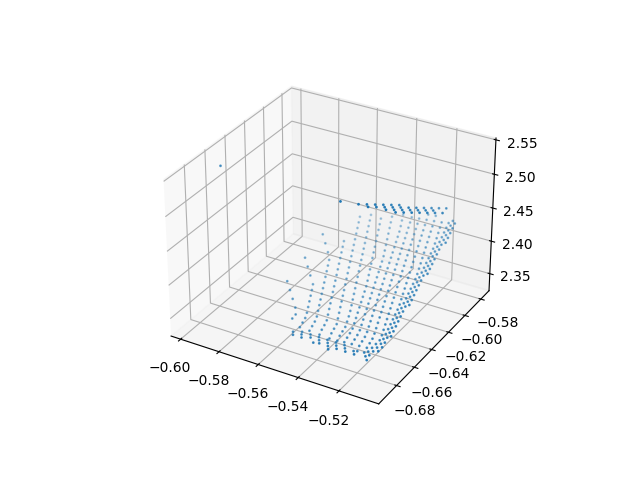

In [10]:
import pyntcloud
import pandas as pd


cloud = pyntcloud.PyntCloud(pd.DataFrame(finite_depth_points, columns=["x","y","z"]))
display(cloud)
k = 20  # Number of nearest neighbors to use
std_ratio = 1.0  # Standard deviation multiplier threshold
kdtree = cloud.add_structure("kdtree")
filt = cloud.get_filter("ROR",k=400, r=0.2, kdtree_id=kdtree)
#filt = cloud.get_filter("SOR",k=10, z_max=0.40, kdtree_id=kdtree)
cloud.apply_filter(filt)
display(cloud)


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
points_np = cloud.points.values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], s=1)
plt.show()

In [11]:
from py_cylinder_fitting import BestFitCylinder
from skspatial.objects import Points

# Assuming extracted_points is a list of 3D points
points = Points(cloud.points.values)
best_fit_cylinder = BestFitCylinder(points)

# Get the cylinder parameters
cylinder_center = best_fit_cylinder.point
cylinder_axis = best_fit_cylinder.vector
cylinder_radius = best_fit_cylinder.radius

print("Cylinder Center:", cylinder_center)
print("Cylinder Axis:", cylinder_axis)
print("Cylinder Radius:", cylinder_radius)

cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

print("Cylinder height: ", cylinder_height)

Cylinder Center: [-0.52998825 -0.64305158  2.33459913]
Cylinder Axis: [-0.00667256  0.01946782  0.11362482]
Cylinder Radius: 0.029553281829059683
Cylinder height:  0.11547345560084106


In [150]:
640*480

307200

In [12]:
from moveit_msgs.srv import ApplyPlanningScene
from moveit_msgs.msg import PlanningScene, CollisionObject
from shape_msgs.msg import SolidPrimitive
from geometry_msgs.msg import Pose

In [13]:
node.client = node.create_client(ApplyPlanningScene, 'apply_planning_scene')

In [14]:
cylinder = CollisionObject()
cylinder.id = "cylinder"
cylinder.header.frame_id = "realsense_link"
cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

# Define the shape of the cylinder
cylinder_primitive = SolidPrimitive()
cylinder_primitive.type = SolidPrimitive.CYLINDER
cylinder_primitive.dimensions = [cylinder_height, cylinder_radius]  # [height, radius]

# Define the pose of the cylinder
cylinder_pose = Pose()
cylinder_pose.position.x = cylinder_center[2]
cylinder_pose.position.y = -cylinder_center[0]
cylinder_pose.position.z = cylinder_center[1]
cylinder_pose.orientation.w = 1.0  # Assuming no rotation

# Add the shape and pose to the collision object
cylinder.primitives.append(cylinder_primitive)
cylinder.primitive_poses.append(cylinder_pose)
cylinder.operation = CollisionObject.ADD

# Create the planning scene message
planning_scene = PlanningScene()
planning_scene.world.collision_objects.append(cylinder)
planning_scene.is_diff = True

# Create the service request
request = ApplyPlanningScene.Request()
request.scene = planning_scene

# Call the service
future = node.client.call_async(request)
rclpy.spin_until_future_complete(node, future)

In [15]:
future.result()


moveit_msgs.srv.ApplyPlanningScene_Response(success=True)

In [155]:
cylinder_radius


0.037908480846359865

In [156]:
cylinder_height

1.9874176237757264

In [157]:
import sensor_msgs_py.point_cloud2 as pc2

In [158]:
points_data = pc2.read_points_numpy(points, field_names=("x","y","z"), reshape_organized_cloud=True, skip_nans=True)

In [159]:
points_data.shape

(640, 480, 3)

In [160]:
points_flat = points_data[y:y+h, x:x+w, :].reshape(-1,3)

In [161]:
points_flat

array([[ 1.2998457 ,  0.6859749 ,  0.41862053],
       [ 1.2951043 ,  0.681136  ,  0.41709352],
       [ 1.2903969 ,  0.6763321 ,  0.4155775 ],
       ...,
       [ 3.3841364 , -1.2242014 ,  0.97997177],
       [ 3.3841364 , -1.2303072 ,  0.97997177],
       [ 3.3841364 , -1.2364129 ,  0.97997177]], dtype=float32)

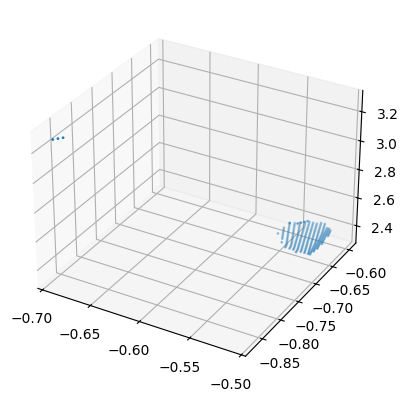

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(finite_depth_points[:, 0], finite_depth_points[:, 1], finite_depth_points[:, 2], s=1)
plt.show()

In [31]:
points_data.size

AttributeError: 'tuple' object has no attribute 'size'

/workspace/myenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [169]:
img_rgb.shape

(480, 640, 3)

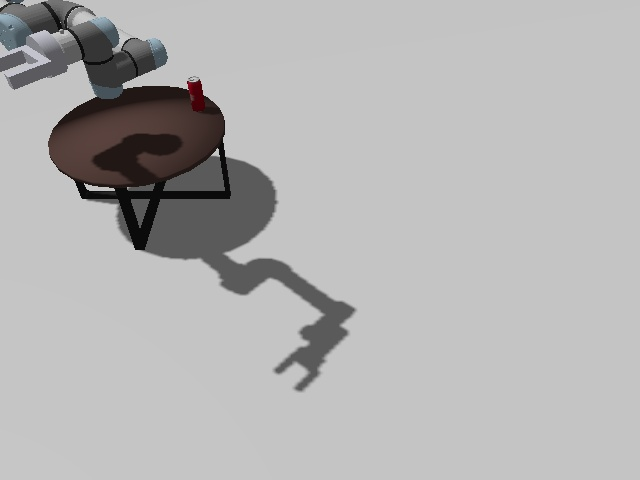

In [146]:
# Assuming img is the OpenCV image you have from the ROS2 topic
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

# Define the red color range and create a mask
lower_red = np.array([0, 120, 70])
upper_red = np.array([10, 255, 255])
mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

lower_red = np.array([170, 120, 70])
upper_red = np.array([180, 255, 255])
mask2 = cv2.inRange(img_hsv, lower_red, upper_red)

mask = mask1 + mask2

# Find contours and draw bounding boxes
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert OpenCV image to PIL image
_, buffer = cv2.imencode('.jpg', img_rgb)
io_buf = io.BytesIO(buffer)
pil_image = PILImage.open(io_buf)

# Display the image
display(pil_image)


In [160]:
from vision_msgs.msg import RecognizeObjectsAction, RecognizeObjectsResult


ImportError: cannot import name 'RecognizeObjectsAction' from 'vision_msgs.msg' (/opt/ros/jazzy/lib/python3.12/site-packages/vision_msgs/msg/__init__.py)

In [20]:
from rclpy.action import ActionServer 
from object_recognition_msgs.action import ObjectRecognition
from object_recognition_msgs.msg import RecognizedObjectArray, RecognizedObject


In [21]:
RecognizedObject.get_fields_and_field_types()

{'header': 'std_msgs/Header',
 'type': 'object_recognition_msgs/ObjectType',
 'confidence': 'float',
 'point_clouds': 'sequence<sensor_msgs/PointCloud2>',
 'bounding_mesh': 'shape_msgs/Mesh',
 'bounding_contours': 'sequence<geometry_msgs/Point>',
 'pose': 'geometry_msgs/PoseWithCovarianceStamped'}

In [19]:
RecognizedObjectArray.get_fields_and_field_types()

{'header': 'std_msgs/Header',
 'objects': 'sequence<object_recognition_msgs/RecognizedObject>',
 'cooccurrence': 'sequence<float>'}

In [ ]:
def action_callback(goal_handle): 
    
    result = ObjectRecognition.Result()
    
    goal_handle.succeed()
    return result

action_server = 